In [1]:
import time
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install geneal
import numpy as np
import pandas as pd
from geneal.genetic_algorithms import ContinuousGenAlgSolver
flowdata = pd.read_excel(r'./flowdata_selected.xlsx', sheet_name='Scenario1')
d2 = pd.read_excel(r'./flowdata_selected.xlsx', sheet_name='Scenario2')
d3 = pd.read_excel(r'./flowdata_selected.xlsx', sheet_name='Scenario3')
d4 = pd.read_excel(r'./flowdata_selected.xlsx', sheet_name='Scenario5')
flowdata = flowdata.append(d2, ignore_index=True)
flowdata = flowdata.append(d3, ignore_index=True)
flowdata = flowdata.append(d4, ignore_index=True)
flowdata = flowdata[['KTB', 'KTC', 'SKB', 'SKC']] # ensure columns ordering is correct

**Equation**:
$$w\times KTB+x\times KTC-y\times SKB-z\times SKC = m = KTB + KTC - SKB - SKC$$

where *m* is the observed mismatch between JRWW and SKL
- Each set of flow values observed for KTB, KTC, SKB, SKC can be geometrically represented as a line in 4-dimensional space mapped by w, x, y, z

$$w\times KTB+x\times KTC-y\times SKB-z\times SKC-(KTB + KTC - SKB - SKC)=0$$

- By iterating through *test_values* for w, x, y, z, we find the point (w,x,y,z) that minimises the sum of the distance between (w,x,y,z) and all the lines

$$\sum distance = \sum\frac{|w\times KTB+x\times KTC-y\times SKB-z\times SKC-(KTB + KTC - SKB - SKC)|}{\sqrt{KTB^2+KTC^2+SKB^2+SKC^2}}$$

- Find *num_results* number of sample points that provide the *num_results* lowest sum of distances
- Each of w, x, y, z is equal to $\frac{E}{1+E}$ where E is the actual flowmeter error

In [2]:
flowdata

,KTB,KTC,SKB,SKC
0,0.0,407.6,0.0,401.4
1,0.0,413.3,230.8,177.8
2,449.7,0.0,252.1,205.2
3,463.6,394.4,472.7,385.9


In [3]:
# prepare raw data
flowdata_temp = flowdata
# change the sign of SKB and SKC columns for simpler arithmetic
flowdata_temp['SKB'] *= -1
flowdata_temp['SKC'] *= -1
flowdata_array = flowdata_temp.to_numpy()

The following genetic algorithm attempts to find the best values of flowmeter errors E1, E2, E3, E4 that minimise the sum of the smallest euclidean distances between the final solution point and the lines formed by all the data provided. The *num_results* best solutions are stored and displayed below.

Iteration: 100
Best fitness: -0.003524032496982265
Iteration: 200
Best fitness: -0.0035240268465864272
Iteration: 300
Best fitness: -0.003524026846586201
Iteration: 400
Best fitness: -0.003524026846586201
Iteration: 500
Best fitness: -0.003524026846586201
Iteration: 600
Best fitness: -0.003524026846586201
Iteration: 700
Best fitness: -0.003524026846586201
Iteration: 800
Best fitness: -0.003524026846586201
Iteration: 900
Best fitness: -0.003524026846586201
Iteration: 1000
Best fitness: -0.003524026846586201


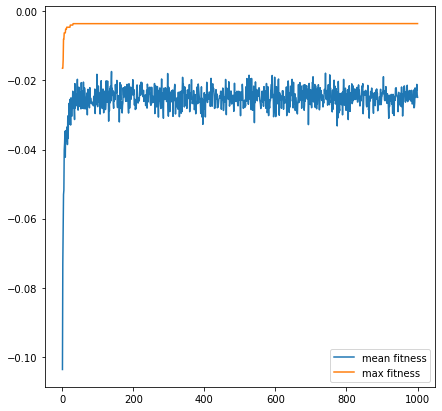


#############################
#			STATS			#
#############################


Total running time: 9 seconds


Population size: 100
Number variables: 4
Selection rate: 0.5
Mutation rate: 0.15
Number Generations: 1000

Best fitness: -0.003524026846586201
Best individual: [-0.82646456  2.13051662  1.07254132  0.57701023]
CPU times: user 8.73 s, sys: 111 ms, total: 8.84 s
Wall time: 9.38 s


In [9]:
%%time

# genetic algorithm
def flow_fitness_function(data):
    def calc_dist(errors):
        sum_of_dist = 0
        #convert errors into variables (w,x,y,z)
        wxyz = np.array(list(map(lambda t:(0.01*t/(1+0.01*t)), errors)))
        for params in data:
            m = sum(params) # mismatch
            dist = abs(np.dot(params, wxyz) - m)/np.linalg.norm(params)
            sum_of_dist += dist
        return -sum_of_dist #inverse because GA maximises the function
    return calc_dist

solver = ContinuousGenAlgSolver(
    n_genes = 4,
    fitness_function = flow_fitness_function(flowdata_array),
    variables_limits = (-5,5)
)

solver.solve()